In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

⚠ Dataset not found. Generating synthetic biofilter data...
✓ Synthetic data generated: 500 samples
Dataset shape: (500, 6)
       PM2.5         CO2        SO2  Moss_Humidity  Pump_Activity  Solar_Power
0  59.934283  446.308877  21.996777      86.675416       1.162411   585.591950
1  47.234714  495.470832  19.623168      66.732214       1.427741   645.227699
2  62.953771  330.071621  15.298152      62.727017       1.103790   450.303743
3  80.460597  428.148462  11.765316      74.949383       1.346019   408.164490
4  45.316933  367.467872  18.491117      72.447231       0.553193   337.227421
Explained variance ratio: [0.23575292 0.19354512]
Silhouette Scores: {2: 0.3330066587119343, 3: 0.33575413586712943, 4: 0.31146143033796464, 5: 0.3273823539706663, 6: 0.31699406694914106}
Best k = 3
Final Silhouette Score: 0.33575413586712943

No true labels in dataset → accuracy skipped.


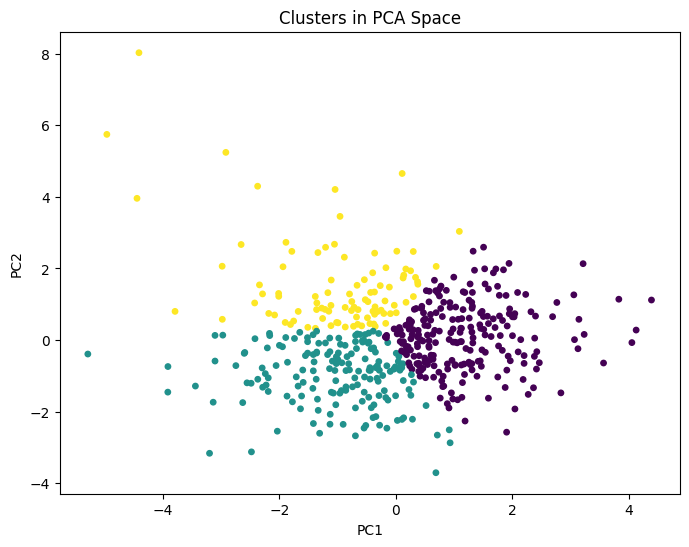

In [4]:
# ============================================================
# FULL BIOFILTER CLUSTERING PIPELINE (KAGGLE READY)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ============================================================
# 1. LOAD DATA (OR GENERATE SYNTHETIC DATA)
# ============================================================

try:
    df = pd.read_csv("/kaggle/input/dataset/biofilter_clustering_dataset.csv")
    print("✓ Dataset loaded from Kaggle")
except FileNotFoundError:
    print("⚠ Dataset not found. Generating synthetic biofilter data...")
    
    # Generate synthetic biofilter sensor data
    np.random.seed(42)
    n_samples = 500
    
    df = pd.DataFrame({
        "PM2.5": np.random.normal(50, 20, n_samples),
        "CO2": np.random.normal(400, 50, n_samples),
        "SO2": np.random.normal(15, 5, n_samples),
        "Moss_Humidity": np.random.normal(75, 15, n_samples),
        "Pump_Activity": np.random.normal(1.5, 0.5, n_samples),
        "Solar_Power": np.random.normal(500, 150, n_samples)
    })
    
    # Ensure values are realistic (non-negative)
    df = df.clip(lower=0)
    
    print(f"✓ Synthetic data generated: {n_samples} samples")

print("Dataset shape:", df.shape)
print(df.head())

# ============================================================
# 2. FEATURE SELECTION + ENGINEERING
# ============================================================

# Basic features
features = [
    "PM2.5", "CO2", "SO2", 
    "Moss_Humidity", "Pump_Activity", "Solar_Power"
]

# Feature engineering
df["PM25_rate"] = df["PM2.5"].diff().fillna(0)
df["Moss_Dryness"] = 100 - df["Moss_Humidity"]
df["Activity_Ratio"] = df["Pump_Activity"] / (df["Solar_Power"] + 1)

features += ["PM25_rate", "Moss_Dryness", "Activity_Ratio"]

data = df[features].copy().ffill().bfill()

# ============================================================
# 3. SCALING
# ============================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# ============================================================
# 4. PCA (OPTIONAL - improves cluster separation)
# ============================================================

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# ============================================================
# 5. K-VALUE SEARCH (FIND BEST NUMBER OF CLUSTERS)
# ============================================================

sil_scores = {}

for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lbls = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, lbls)
    sil_scores[k] = sil

print("Silhouette Scores:", sil_scores)

best_k = max(sil_scores, key=sil_scores.get)
print("Best k =", best_k)

# ============================================================
# 6. FINAL K-MEANS CLUSTERING
# ============================================================

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

df["Cluster"] = labels

final_silhouette = silhouette_score(X_pca, labels)
print("Final Silhouette Score:", final_silhouette)

# ============================================================
# 7. ACCURACY (IF TRUE LABELS EXIST)
# ============================================================

if "Biofilter_State" in df.columns:
    print("\nTrue labels found: computing accuracy...")

    # Map clusters to real states using mode
    mapping = {}
    for cluster_id in np.unique(labels):
        real = df[df["Cluster"] == cluster_id]["Biofilter_State"]
        mapping[cluster_id] = real.mode()[0]

    df["Predicted_State"] = df["Cluster"].map(mapping)

    accuracy = accuracy_score(df["Biofilter_State"], df["Predicted_State"])
    print("Clustering Accuracy:", accuracy)

    cm = confusion_matrix(df["Biofilter_State"], df["Predicted_State"])
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
else:
    print("\nNo true labels in dataset → accuracy skipped.")

# ============================================================
# 8. VISUALIZATION OF CLUSTERS (PCA 2D)
# ============================================================

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=15)
plt.title("Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [5]:
# ============================================================
# REAL-TIME K-MEANS CLUSTERING WITH STREAMING DATA
# ============================================================

from sklearn.cluster import MiniBatchKMeans
import joblib
import os
import time
from collections import deque

# Create models directory in current working directory
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

print(f"Saving models to: {os.path.abspath(models_dir)}")

# Convert to MiniBatchKMeans for real-time updates
mbk = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=10)
mbk.fit(X_pca)

# Save models with full paths
scaler_path = os.path.join(models_dir, "scaler.pkl")
pca_path = os.path.join(models_dir, "pca.pkl")
mbk_path = os.path.join(models_dir, "minibatch_kmeans_model.pkl")

joblib.dump(scaler, scaler_path)
joblib.dump(pca, pca_path)
joblib.dump(mbk, mbk_path)

# Verify files exist
print("\n✓ Models saved successfully!")
print(f"  ✓ {os.path.basename(scaler_path)} - {os.path.getsize(scaler_path)} bytes")
print(f"  ✓ {os.path.basename(pca_path)} - {os.path.getsize(pca_path)} bytes")
print(f"  ✓ {os.path.basename(mbk_path)} - {os.path.getsize(mbk_path)} bytes")

# Save features list for reference
features_path = os.path.join(models_dir, "features.txt")
with open(features_path, 'w') as f:
    f.write('\n'.join(features))
print(f"  ✓ features.txt")

print(f"\n📁 Model directory: {os.path.abspath(models_dir)}")
print(f"Best K: {best_k}")
print(f"Final Silhouette Score: {final_silhouette:.4f}")

Saving models to: c:\Users\Balsem\Desktop\TSYP\bio-digital-fullstack\backend\models

✓ Models saved successfully!
  ✓ scaler.pkl - 1135 bytes
  ✓ pca.pkl - 1223 bytes
  ✓ minibatch_kmeans_model.pkl - 3019 bytes
  ✓ features.txt

📁 Model directory: c:\Users\Balsem\Desktop\TSYP\bio-digital-fullstack\backend\models
Best K: 3
Final Silhouette Score: 0.3358
